## Local Differential Privacy (LDP Modifier CNN)
To utilize local differential privacy (DP) and add noise to the client model parameters before transmitting them to the server in Flower, you can use the LocalDpMod.



---

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr 

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.19.0



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../..")

import ray
import time

import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp
from flwr.client.mod import LocalDpMod
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from src.config import ExperimentName
from src.paths import RAY_LOG_DIR
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn
from src.local_utility import load_yaml_config, set_device, prepare_FL_dataset, get_weights

from src.tracker import reset_base_memory_csv

In [3]:
# Replace with appropritate values

data_name_ = "skin_lesions" #'alzheimer' #
base_type_ = "CNN"           
exp_name_ = "LDP-Mod"
num_labels_ = 8 #4
experiment_name_ = ExperimentName.FL_LDP_MOD_CNN

In [4]:
DEVICE = set_device()
reset_base_memory_csv() 

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name= exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True)

In [5]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name=exp_name_, data_name = data_name_, base_type=base_type_, client_id=partition_id).to_client()


# Create an instance of the mod with the required params
local_dp_obj = LocalDpMod(clipping_norm=50.0, sensitivity=0.02, epsilon=0.4, delta=1e-5)

client = ClientApp(client_fn, mods=[local_dp_obj])

In [6]:
def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)
    params = ndarrays_to_parameters(get_weights(model))
    
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )
    
    
    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=fed_config['num_rounds'])
    
    return ServerAppComponents(strategy = strategy, config = sever_config)

# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

In [7]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-07-24 16:45:45,904	INFO worker.py:1771 -- Started a local Ray instance.
2025-07-24 16:45:45,988	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-07-24 16:45:46,101	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_4dcbe08a88e194a6.zip' (14.71MiB) to Ray cluster...
2025-07-24 16:45:46,147	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_4dcbe08a88e194a6.zip'.
07/24/2025 16:45:47:DEBUG:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
[codecarbon WARNING @ 16:45:47] Multiple instances of codecarbon are allowed to run at the same time.
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This pr

(ClientAppActor pid=69490) 
(ClientAppActor pid=69490) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69490) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69490) ⏱️ Total training time: 2 minutes 12 seconds


(ClientAppActor pid=69490) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
(ClientAppActor pid=69490)   df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()
(ClientAppActor pid=69490) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) 07/24/2025 16:48:19:INFO:LocalDpMod: parameters are cl

(ClientAppActor pid=69489) 


(ClientAppActor pid=69490) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69490) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69490)   self.pid = os.fork()
(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 16:48:23:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 16:48:24:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters


(ClientAppActor pid=69490) 
(ClientAppActor pid=69490) 🔎 Tracker: FL + LDP-Mod (CNN) [repeated 2x across cluster]
(ClientAppActor pid=69490) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=69490) ⏱️ Total training time: 2 minutes 6 seconds [repeated 2x across cluster]


(ClientAppActor pid=69490) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) 07/24/2025 16:50:27:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69490) 07/24/2025 16:50:27:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
INFO :      aggregate_fit: received 3 results and 0 failures
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=60422) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (1, nan, {'accuracy': 0.18344086021505376}, 277.39718763900055)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python

(ClientAppActor pid=69489) 
(ClientAppActor pid=69489) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69489) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69489) ⏱️ Total training time: 1 minutes 42 seconds


(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 16:52:20:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 16:52:20:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) Seed set to 42
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()


(ClientAppActor pid=69490) 
(ClientAppActor pid=69490) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69490) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69490) ⏱️ Total training time: 2 minutes 8 seconds


(ClientAppActor pid=69490) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) 07/24/2025 16:52:45:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69490) 07/24/2025 16:52:46:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()


(ClientAppActor pid=69489) 
(ClientAppActor pid=69489) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69489) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69489) ⏱️ Total training time: 1 minutes 36 seconds


(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 16:53:57:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 16:53:57:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
INFO :      aggregate_fit: received 3 results and 0 failures
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=60422) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (2, nan, {'accuracy': 0.18344086021505376}, 487.1624001529999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3

(ClientAppActor pid=69489) 
(ClientAppActor pid=69489) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69489) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69489) ⏱️ Total training time: 1 minutes 42 seconds


(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 16:55:49:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 16:55:49:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) Seed set to 42
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()


(ClientAppActor pid=69490) 
(ClientAppActor pid=69490) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69490) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69490) ⏱️ Total training time: 2 minutes 8 seconds


(ClientAppActor pid=69490) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) 07/24/2025 16:56:15:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69490) 07/24/2025 16:56:15:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()


(ClientAppActor pid=69489) 
(ClientAppActor pid=69489) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69489) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69489) ⏱️ Total training time: 1 minutes 36 seconds


(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 16:57:26:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 16:57:27:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
INFO :      aggregate_fit: received 3 results and 0 failures
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=60422) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (3, nan, {'accuracy': 0.18344086021505376}, 696.3754051449996)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3

(ClientAppActor pid=69489) 
(ClientAppActor pid=69489) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69489) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69489) ⏱️ Total training time: 1 minutes 41 seconds


(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 16:59:17:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 16:59:17:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) Seed set to 42
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()


(ClientAppActor pid=69490) 
(ClientAppActor pid=69490) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69490) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69490) ⏱️ Total training time: 2 minutes 8 seconds


(ClientAppActor pid=69490) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) 07/24/2025 16:59:44:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69490) 07/24/2025 16:59:45:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()


(ClientAppActor pid=69489) 
(ClientAppActor pid=69489) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69489) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69489) ⏱️ Total training time: 1 minutes 37 seconds


(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 17:00:55:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 17:00:55:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
INFO :      aggregate_fit: received 3 results and 0 failures
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=60422) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (4, nan, {'accuracy': 0.18344086021505376}, 905.6990352700013)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3

(ClientAppActor pid=69489) 
(ClientAppActor pid=69489) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69489) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69489) ⏱️ Total training time: 1 minutes 41 seconds


(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 17:02:46:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 17:02:46:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) Seed set to 42
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()


(ClientAppActor pid=69490) 
(ClientAppActor pid=69490) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69490) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69490) ⏱️ Total training time: 2 minutes 8 seconds


(ClientAppActor pid=69490) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) 07/24/2025 17:03:13:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69490) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69490) 07/24/2025 17:03:14:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()


(ClientAppActor pid=69489) 
(ClientAppActor pid=69489) 🔎 Tracker: FL + LDP-Mod (CNN)
(ClientAppActor pid=69489) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-Mod_CNN/client_emissions.csv
(ClientAppActor pid=69489) ⏱️ Total training time: 1 minutes 36 seconds


(ClientAppActor pid=69489) INFO :      LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) 07/24/2025 17:04:23:INFO:LocalDpMod: parameters are clipped by value: 50.0000.
(ClientAppActor pid=69489) INFO :      LocalDpMod: local DP noise with 0.2422 stedv added to parameters
(ClientAppActor pid=69489) 07/24/2025 17:04:24:INFO:LocalDpMod: local DP noise with 0.2422 stedv added to parameters
INFO :      aggregate_fit: received 3 results and 0 failures
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=60422) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
wandb: Currently logged in as: emyrs to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor 

/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=60422) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



 ___________________________________________________________________________________________________
ExperimentName.FL_LDP_MOD_CNN Model Final Evaluation 

Test Accuracy: 18.34% | Precision: 0.03 | Recall: 0.18 | F1-Score: 0.06 | ROC-AUC: 0.54 | MCC: 0.00
 


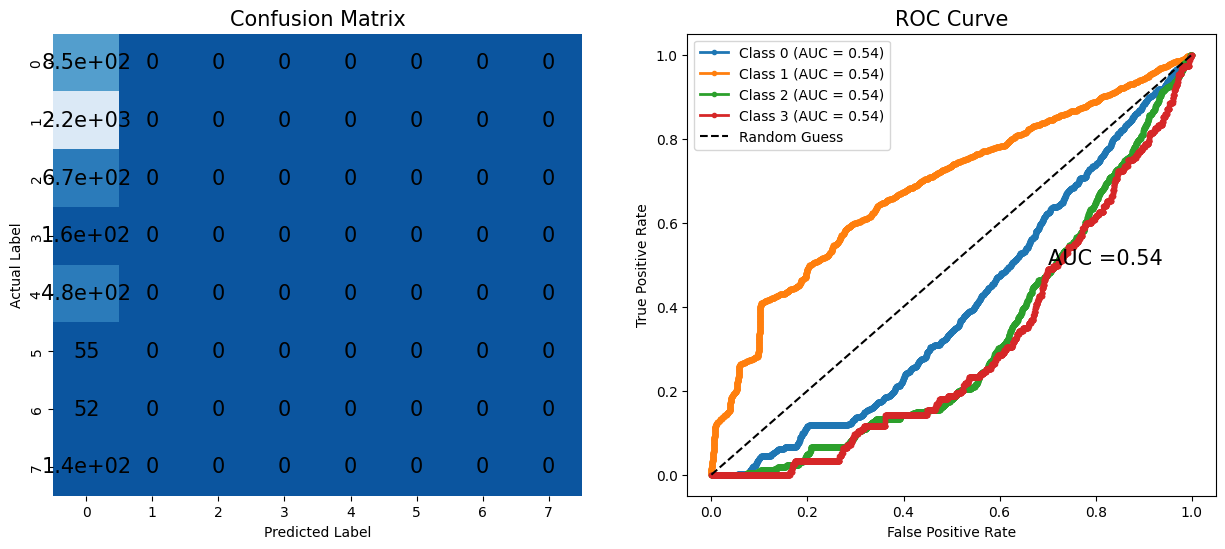


 ___________________________________________________________________________________________________
ExperimentName.FL_LDP_MOD_CNN--skin_lesions Model Classification Report
              precision    recall  f1-score   support

           0       0.18      1.00      0.31       853
           1       0.00      0.00      0.00      2242
           2       0.00      0.00      0.00       674
           3       0.00      0.00      0.00       155
           4       0.00      0.00      0.00       476
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00        52
           7       0.00      0.00      0.00       143

    accuracy                           0.18      4650
   macro avg       0.02      0.12      0.04      4650
weighted avg       0.03      0.18      0.06      4650

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 5023.79 sec
✅ Total Energy: 0.0

Accuracy,▁
F1-Score,▁
MCC,▁
Peak FL CPU RAM (GB),▁
Peak FL GPU VRAM (GB),▁
Precision,▁
ROC-AUC,▁
Recall,▁
Total FL CO2 Emitted (kg),▁
Total FL Duration (sec),▁
Total FL Energy (kWh),▁


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
INFO :      fit progress: (5, nan, {'accuracy': 0.18344086021505376}, 1123.0592087599998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=69489) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=69489) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=69489)   self.pid = os.fork()
INFO :      aggregate_evaluate: received 3 results and 0 failures
IN


🕒 Total Time: 18 min 57 sec


In [8]:
project_root =  os.path.abspath("../..")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR),
    runtime_env={
        "env_vars": {
            "PYTHONWARNINGS": "ignore::DeprecationWarning",  # More specific warning filter
            "OMP_NUM_THREADS": "1"  # Prevents thread oversubscription
        },
        "working_dir": project_root,
        'excludes': ['data', '.cache', '.docker', '.local', 'logs/model']
    },
    ignore_reinit_error=True
)

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"),
    backend_config=backend_setup
)


end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()